In [1]:
# Import main packages
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)
# Other global libraries
import matplotlib.pyplot as plt
import matplotlib
import wget
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from skimage.morphology import closing ,opening, disk
#from typing import Callable
#import copy
#import torch
#from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm
from typing import Optional, Callable
from skimage import util , morphology , color
from skimage.color import rgb2hsv
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
#from sklearn.metrics import accuracy_score, f1_score
#from sklearn.covariance import LedoitWolf

/opt/anaconda3/envs/iapr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-0.5, 5999.5, 3999.5, -0.5)

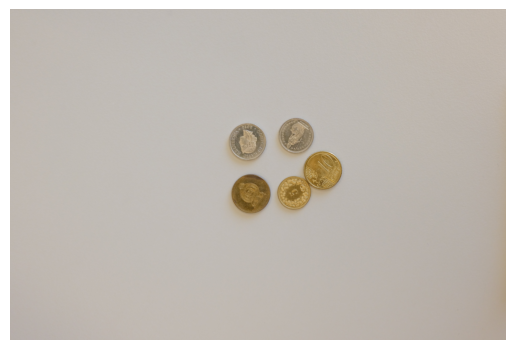

In [2]:
path_neutralbg = os.path.join("Data", "train", "4. neutral_bg_outliers","L1010424.JPG")
path_noisybg = os.path.join("Data", "train", "2. noisy_bg","L1010345.JPG")
path_hand = os.path.join( "Data", "train", "3. hand","L1010373.JPG")
# Check if folder and image exist
assert os.path.exists(path_neutralbg), "Image not found, please check directory structure"
assert os.path.exists(path_noisybg), "Image not found, please check directory structure"
assert os.path.exists(path_hand), "Image not found, please check directory structure"
# Load images
img_nebg = np.array(Image.open(path_neutralbg))
img_nobg = np.array(Image.open(path_noisybg))
img_hand = np.array(Image.open(path_hand))


# Display images
plt.imshow(img_nebg)
#plt.imshow(img_nobg,img_hand)
#plt.imshow(img_hand)
plt.axis('off')

In [3]:
#fonctions opening/closing/remove small objects / ectract hsv 
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    hsv_img = rgb2hsv(img)

    data_h = hsv_img[:, :, 0]
    data_s = hsv_img[:, :, 1]
    data_v = hsv_img[:, :, 2]

    return data_h, data_s, data_v


def apply_closing(img_th, disk_size):
    """
    Apply closing to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for closing

    Return
    ------
    img_closing: np.ndarray (M, N)
        Image after closing operation
    """

    # Define default value for output image
    img_closing = np.zeros_like(img_th)

    img_closing= closing(img_th, disk(disk_size))
    
    return img_closing


def apply_opening(img_th, disk_size):
    """
    Apply opening to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_opening: np.ndarray (M, N)
        Image after opening operation
    """

    # Define default value for output image
    img_opening = np.zeros_like(img_th)

    img_opening= opening(img_th, disk(disk_size))

    return img_opening


def remove_objects(img_th, size):
    """
    Remove objects from input image that are smaller than size argument.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    size: int
        Minimal size of objects

    Return
    ------
    img_obj: np.ndarray (M, N)
        Image after remove small objects operation
    """

    # Define default value for input image
    img_obj = np.zeros_like(img_th)

    arr_int = img_th.astype(bool)

    img_obj= remove_small_objects(arr_int, size)

    return img_obj

In [4]:
def img_process_noisy(img):

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))
    img_opening = np.zeros((M, N))
    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)


    img_th[(data_s >  0.4) & (data_h < 0.12) ] = 1
    img_opening = apply_opening(img_th,  5)
    img_closing = apply_closing(img_opening, 25)
    img_finale  = remove_objects(img_closing, 500)
    label_image = label(img_finale)
    return  label_image

def img_process_neutre(img):

    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
 
    img_th [(data_s >  0.2)  ] = 1
    cleared = clear_border(img_th)
    imgclosing = apply_closing(cleared, 15)
    # img_opening = apply_opening(img_th,  5)
    label_image = label(imgclosing)
    return  label_image

def img_process_hand(img):

    # Define the default value for the input image
    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
 
    img_th [(data_s >  0.2)  ] = 1
    cleared = clear_border(img_th)
    imgclosing = apply_closing(cleared, 15)
       # img_opening = apply_opening(img_th,  5)

    
    return  imgclosing

In [22]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from skimage.measure import regionprops


#A revoire 
def detect_and_store_coin_locations( imag , label_image, area_threshold=500, eccentricity_threshold=0.3, display=False):
    #imag = image originale
    coin_locations = []

    if display:
        fig, ax = plt.subplots()
        ax.imshow(imag, cmap=plt.cm.gray)

    for region in regionprops(label_image):
        # Take regions with large enough areas and low eccentricity
        if (region.area >= area_threshold) & (region.eccentricity < eccentricity_threshold):
            # Get the bounding box coordinates
            minr, minc, maxr, maxc = region.bbox
            # Draw rectangle around segmented coins
            if display:
                rect = mpatches.Rectangle(
                    (minc, minr),
                    maxc - minc,
                    maxr - minr,
                    fill=False,
                    edgecolor='red',
                    linewidth=2,
                )
                ax.add_patch(rect)
            # Store the coordinates of the bounding box
            coin_locations.append((minr, minc, maxr, maxc))

    if display:
        plt.show()

    return coin_locations

# Example usage
# label_image = ... # Your label image here
# coin_locations = detect_and_store_coin_locations(label_image, display=True)
# print(coin_locations)  # This will print the list of bounding box coordinates

# To crop the detected coins later, you can use the stored coordinates
# for minr, minc, maxr, maxc in coin_locations:
#     cropped_coin = label_image[minr:maxr, minc:maxc]


In [26]:

def process_and_crop_coins(img, coin_locations, display=True, cols=5, figsize=(15, 15)):
    """
    Crop coins from an image based on provided locations, optionally display them.
    
    Parameters:
    img (numpy array): The input image.
    coin_locations (list of tuples): List of tuples containing the coordinates (minr, minc, maxr, maxc) for each coin.
    display (bool): Whether to display the cropped coins. Default is True.
    cols (int): Number of columns in the grid layout for display. Default is 5.
    figsize (tuple): Size of the figure for display. Default is (15, 15).
    
    Returns:
    List of numpy arrays: List of cropped coin images.
    """
    num_coins = len(coin_locations)
    cropped_coins = []

    if num_coins == 0:
        print("No coins to display.")
        return cropped_coins
    else:
        rows = (num_coins + cols - 1) // cols  # Number of rows in the grid

        if display:
            fig, axes = plt.subplots(rows, cols, figsize=figsize)
            # Flatten the axes array for easier indexing
            axes = axes.flatten()

        for i, (minr, minc, maxr, maxc) in enumerate(coin_locations):
            cropped_coin = img[minr:maxr, minc:maxc]
            cropped_coins.append(cropped_coin)
            
            if display:
                axes[i].imshow(cropped_coin, cmap='gray')
                axes[i].axis('off')

        if display:
            # Hide any unused subplots
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])
            plt.tight_layout()
            plt.show()
        
    return cropped_coins

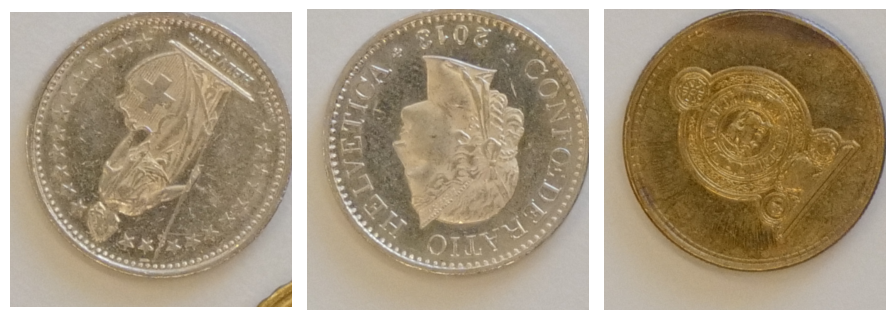

In [27]:

img_th = img_process_neutre(img_nebg)
coin_locations = detect_and_store_coin_locations(imag= img_nebg, label_image=img_th,eccentricity_threshold=0.5, display=False)
cropped_coins = process_and_crop_coins(img_nebg, coin_locations, display=True)


In [ ]:
def process_image(img , type ,diplay_crop = False)
    if (type == "neutre") :
        img_th = img_process_neutre(img)
        coin_locations = detect_and_store_coin_locations(imag= img, label_image=img_th,eccentricity_threshold=0.5, display=False)
        cropped_coins = process_and_crop_coins(img, coin_locations, display= diplay_crop)

    if (type == "noisy") :
        img_th = img_process_noisy(img)
        coin_locations = detect_and_store_coin_locations(imag= img, label_image=img_th,eccentricity_threshold=0.5, display=False)
        cropped_coins = process_and_crop_coins(img, coin_locations, display=diplay_crop)

return cropped_coins